# Python Reinforcement Learning Trader for Cryptocurrency

#### Installs and imports

In [2]:
# Installs
!pip install -q rich markdown-it-py tensorflow-cpu tensorflow gym-anytrading gym==0.21.0 torch==2.0.1 numpy keras python-binance seaborn ipykernel stable-baselines3[extra]
!pip install -q tensorboard scikit-learn

In [3]:
# Imports
# System utils 
import os
from IPython.core.interactiveshell import InteractiveShell
import time
import importlib

# Crypto
from binance.streams import BinanceSocketManager
from binance.client import Client
import binance.helpers as btime
from binance.depthcache import DepthCacheManager

# Data Processing
import numpy as np
import pandas as pd

# Environment
import gym
from tradinggym import CryptoEnvironment

# Plotting
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

import seaborn as sns

# Reinforcement Learning
import tensorflow as tf
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import DQN
from stable_baselines3 import PPO
import logging

In [4]:
# NB Setup
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
logging.basicConfig(level=logging.INFO)

#### Set Up Binance Client

The Binance Client interface allows us to pull candlestick data from the Binance.US api. 

We will perform measurements on this data that allow us to summarize trends and indicators.

In [5]:
if not os.path.exists('./data/measurement.pickle'): # If data has not already been saved
    # Set up Binance Client
    api_key = 'YOUR_API_KEY'
    api_secret = 'YOUR_API_SECRET'
    client=Client(api_key=api_key,api_secret=api_secret,tld='US')

    # Define trading environment
    base_asset = 'BTC'
    quote_asset = 'USDT'
    trade_pair = base_asset+quote_asset

    # Define request interval
    time_interval = Client.KLINE_INTERVAL_5MINUTE

    # Get historical klines data
    klines = client.get_historical_klines(symbol=trade_pair, interval=time_interval, start_str='1 Jan,2022')
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    measurement = pd.DataFrame(klines, columns=columns).drop(columns=['ignore', 'close_time'])
    measurement.head()
    measurement.shape

    # Convert raw data types
    for col in measurement.columns[1:]:
        measurement[col] = measurement[col].astype(float)
    measurement['open_time'] = measurement['open_time'].astype('uint64')

else:
    measurement = pd.read_pickle('./data/measurement.pickle') # Otherwise load data from disk


#### Perform measurements
Here we perform various measurements on the candlestick data to extract useful features in the observation space.
We also remove highly cross-correlated features and reformat data.

In [6]:
# Measure indicators and clean data
def measure(klines):

    candles = klines.copy(deep=True)
    # Compute technical indicators

    # VWAP
    candles['typical_price'] = (candles['high'] + candles['low'] + candles['close']) / 3
    candles['VWAP'] = (candles['volume'] * candles['typical_price']).cumsum() / candles['volume'].cumsum()

    # MACD
    exp12 = candles['close'].ewm(span=12, adjust=False).mean()
    exp26 = candles['close'].ewm(span=26, adjust=False).mean()
    macd_line = exp12 - exp26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    candles['MACD'] = macd_line - signal_line

    # ROC1 
    candles['ROC1'] = candles['close'].pct_change(periods=1)

    # CMF
    candles['MF_Multiplier'] = (2*candles['close'] - candles['low'] - candles['high']) / (candles['high'] - candles['low'])
    candles['MF_Volume'] = candles['MF_Multiplier'] * candles['volume']
    candles['CMF'] = candles['MF_Volume'].rolling(window=20).sum() / candles['volume'].rolling(window=20).sum()

    # RSI
    delta = candles['close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up/ema_down
    candles['RSI'] = 100 - (100/(1 + rs))

    # AROON
    n = 14
    candles['aroon_up'] = ((candles['high'].rolling(n).apply(np.argmax) + 1) / n) * 100
    candles['aroon_down'] = ((candles['low'].rolling(n).apply(np.argmin) + 1) / n) * 100
    candles['AROON'] = candles['aroon_up'] - candles['aroon_down']

    # ATR
    high_low = candles['high'] - candles['low']
    high_close = np.abs(candles['high'] - candles['close'].shift())
    low_close = np.abs(candles['low'] - candles['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    candles['ATR'] = true_range.rolling(14).mean()

    # Ichimoku Cloud
    conversion_line_period = 9 
    base_line_period = 26 
    leading_spans_lookahead_period = 26 
    leading_span_b_period = 52 
    candles['conversion_line'] = (candles['high'].rolling(window=conversion_line_period).max() + candles['low'].rolling(window=conversion_line_period).min()) / 2
    candles['base_line'] = (candles['high'].rolling(window=base_line_period).max() + candles['low'].rolling(window=base_line_period).min()) / 2
    candles['leading_span_A'] = ((candles['conversion_line'] + candles['base_line']) / 2).shift(leading_spans_lookahead_period)
    candles['leading_span_B'] = ((candles['high'].rolling(window=leading_span_b_period).max() + candles['low'].rolling(window=leading_span_b_period).min()) / 2).shift(leading_spans_lookahead_period)


    # Stochastic Oscillator
    k_period = 14
    d_period = 3
    candles['L14'] = candles['low'].rolling(window=k_period).min()
    candles['H14'] = candles['high'].rolling(window=k_period).max()
    candles['%K'] = 100*((candles['close'] - candles['L14']) / (candles['H14'] - candles['L14']))
    candles['%D'] = candles['%K'].rolling(window=d_period).mean()

    # Williams %R
    look_back_period = 14
    candles['Highest_High'] = candles['high'].rolling(window=look_back_period).max()
    candles['Lowest_Low'] = candles['low'].rolling(window=look_back_period).min()
    candles['%R'] = -100 * ((candles['Highest_High'] - candles['close']) / (candles['Highest_High'] - candles['Lowest_Low']))

    # KC
    keltner_period = 20
    keltner_multiplier = 2

    candles['KATR'] = candles[['high', 'low', 'close']].apply(
        lambda x: max(x['high'] - x['low'], abs(x['high'] - x['close']), abs(x['low'] - x['close'])), axis=1
    )
    candles['KCM'] = candles['close'].rolling(window=keltner_period).mean()
    candles['KCU'] = candles['KCM'] + (keltner_multiplier * candles['KATR'])
    candles['KCL'] = candles['KCM'] - (keltner_multiplier * candles['KATR'])

    # DMI
    candles['tr'] = np.maximum.reduce([candles['high'] - candles['low'], np.abs(candles['high'] - candles['close'].shift(1)), np.abs(candles['low'] - candles['close'].shift(1))])
    candles['plus_dm'] = np.where((candles['high'] - candles['high'].shift(1)) > (candles['low'].shift(1) - candles['low']), candles['high'] - candles['high'].shift(1), 0)
    candles['minus_dm'] = np.where((candles['low'].shift(1) - candles['low']) > (candles['high'] - candles['high'].shift(1)), candles['low'].shift(1) - candles['low'], 0)
    candles['tr_rolling'] = candles['tr'].rolling(window=14).sum()
    candles['plus_dm_rolling'] = candles['plus_dm'].rolling(window=14).sum()
    candles['minus_dm_rolling'] = candles['minus_dm'].rolling(window=14).sum()
    candles['di_plus'] = 100 * candles['plus_dm_rolling'] / candles['tr_rolling']
    candles['di_minus'] = 100 * candles['minus_dm_rolling'] / candles['tr_rolling']
    candles['dx'] = 100 * np.abs(candles['di_plus'] - candles['di_minus']) / (candles['di_plus'] + candles['di_minus'])
    candles['ADX'] = candles['dx'].rolling(window=14).mean()

    # CMO
    candles['CMO'] = ((candles['close'].diff(1) > 0).rolling(window=20).sum() - \
                    (candles['close'].diff(1) < 0).rolling(window=20).sum()) / (candles['close'].diff(1).abs().rolling(window=20).sum() + 0.000001) * 100

    # DPO
    candles['DPO'] = candles['close'].shift(int(0.5 * (50 + 1))) - candles['close'].rolling(window=50).mean()

    # EMV
    candles['EMV'] = ((candles['high'] + candles['low']) / 2 - (candles['high'].shift(1) + candles['low'].shift(1)) / 2) \
        / ((candles['volume']) / (candles['high'] - candles['low']))

    # FI
    candles['FI'] = (candles['close'].diff(1) * candles['volume']).rolling(window=13).sum()

    # KVO 
    candles['KVO'] = (candles['volume'] * ((candles['close'] - candles['close'].shift(1)) \
                                        / candles['close'].shift(1) - (candles['volume'].rolling(window=34).mean() \
                                                                        / candles['volume'].rolling(window=55).mean() - 1))).rolling(window=13).sum()

    # MI
    candles['range'] = candles['high'] - candles['low']
    candles['exponential_avg_range'] = candles['range'].ewm(span=9, adjust=False).mean()
    candles['sum_exponential_avg_range'] = candles['exponential_avg_range'].rolling(window=25).sum()
    candles['sum_sum_exponential_avg_range'] = candles['sum_exponential_avg_range'].rolling(window=25).sum()
    candles['MI'] = candles['sum_exponential_avg_range'] / candles['sum_sum_exponential_avg_range']

    # SRSI
    gain = np.where(candles['close'] > candles['close'].shift(1), candles['close'] - candles['close'].shift(1), 0)
    loss = np.where(candles['close'] < candles['close'].shift(1), candles['close'].shift(1) - candles['close'], 0)
    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()
    rs = avg_gain / avg_loss
    stochrsi = (rs - rs.rolling(window=14).min()) / (rs.rolling(window=14).max() - rs.rolling(window=14).min())
    candles['close'].diff()
    candles['RSI'] = candles['close'].diff().rolling(window=14).apply(lambda x: x[x > 0].sum() / x[x < 0].sum(), raw=True)
    candles['MINRSI'] = candles['RSI'].rolling(window=14).min()
    candles['MAXRSI'] = candles['RSI'].rolling(window=14).max()
    candles['DIFFRSI'] = candles['MAXRSI'] - candles['MINRSI']
    candles['SRSI'] = (candles['RSI'] - candles['MINRSI']) / (candles['MAXRSI'] - candles['MINRSI'])

    # TRIX
    candles['EMA1'] = candles['close'].ewm(span=1, adjust=False).mean()
    candles['EMA2'] = candles['close'].ewm(span=2, adjust=False).mean()
    candles['EMA3'] = candles['close'].ewm(span=3, adjust=False).mean()
    candles['TRIX'] = candles['EMA3'].pct_change(periods=1)
    candles['TRIX_SIG'] = candles['TRIX'].ewm(span=9, adjust=False).mean()
    candles['TRIX_HIST'] = candles['TRIX'] - candles['TRIX_SIG']

    # VO
    candles['VO'] = candles['volume'].rolling(window=14).mean() - candles['volume'].rolling(window=28).mean()

    # AO
    candles['AO'] = (candles['high'].rolling(window=5).mean() + candles['low'].rolling(window=5).mean()) / 2 - \
        (candles['high'].rolling(window=34).mean() + candles['low'].rolling(window=34).mean()) / 2
    
    # Drop highly correlated columns
    candles.drop(columns=['typical_price','MF_Multiplier','MF_Volume','aroon_up','aroon_down','L14','H14', 
                          'Highest_High','Lowest_Low','tr','plus_dm','minus_dm','tr_rolling','plus_dm_rolling',
                            'minus_dm_rolling','di_plus','di_minus','dx','sum_exponential_avg_range','sum_sum_exponential_avg_range',
                                'exponential_avg_range','EMA1','EMA2','EMA3'],inplace=True)
    candles = candles.iloc[110:].reset_index(drop=True)
    candles.drop(columns=['VWAP', 'MACD', 'ROC1', 'CMF', 'ATR', 'conversion_line', 'ADX', 'CMO', 'DPO', 'KVO', 'VO',
                          'number_of_trades', 'RSI', 'base_line', 'EMV', 'MI','leading_span_A','leading_span_B','range', '%R','quote_asset_volume',
                          'taker_buy_base_asset_volume','KCM','TRIX','TRIX_SIG','%K','MINRSI','MAXRSI','KATR'],inplace=True)
    
    
    candles.rename(columns={'volume': 'Volume',
                            'open' : 'Open',
                            'high' : 'High',
                            'low'  : 'Low',
                            'close': 'Close'},inplace=True)
    
    candles.set_index('open_time',inplace=True)
    return candles


#### Verify Data

(144634, 15)

,Open,High,Low,Close,Volume,taker_buy_quote_asset_volume,AROON,%D,KCU,KCL,FI,DIFFRSI,SRSI,TRIX_HIST,AO
open_time,,,,,,,,,,,,,,,
1641028200000,47142.39,47142.39,47142.39,47142.39,0.000000,0.000000,-50.0,25.179543,47170.9185,47170.9185,-29.604093,2.268637,0.921130,0.000172,10.694618
1641028500000,47142.39,47142.39,47142.02,47142.02,0.003924,0.000000,-50.0,28.406955,47176.5515,47175.0715,-30.705597,2.268637,0.870136,0.000120,8.697912
1641028800000,47142.02,47142.02,47142.02,47142.02,0.000000,0.000000,-50.0,28.360903,47179.2515,47179.2515,-36.811017,2.268637,0.898510,0.000091,12.269794
1641029100000,47103.27,47124.42,47103.27,47124.42,0.006091,286.978747,-50.0,26.124242,47222.5195,47137.9195,-21.958556,1.749303,1.000000,-0.000079,15.217794
1641029400000,47112.96,47118.73,47112.96,47118.73,0.031840,0.000000,-50.0,23.225421,47190.9215,47167.8415,-24.834712,1.749303,0.948227,-0.000038,13.979676


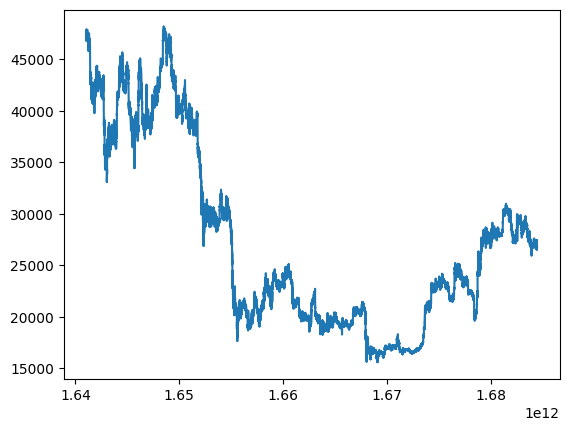

In [7]:
# Perform test measurement
if not os.path.exists('./data/measurement.pickle'): # Load measurement if it doesn't exist already
    measurement = measure(measurement)
    measurement.to_pickle('./data/measurement.pickle')

# Measurement DF is guaranteed to exist at this point
measurement.shape # Make sure the shape is correct
measurement.head()
# Plot the sample klines data
fig, ax = plt.subplots()
ax.plot(measurement['Open'])



#### Visualize Observation Features

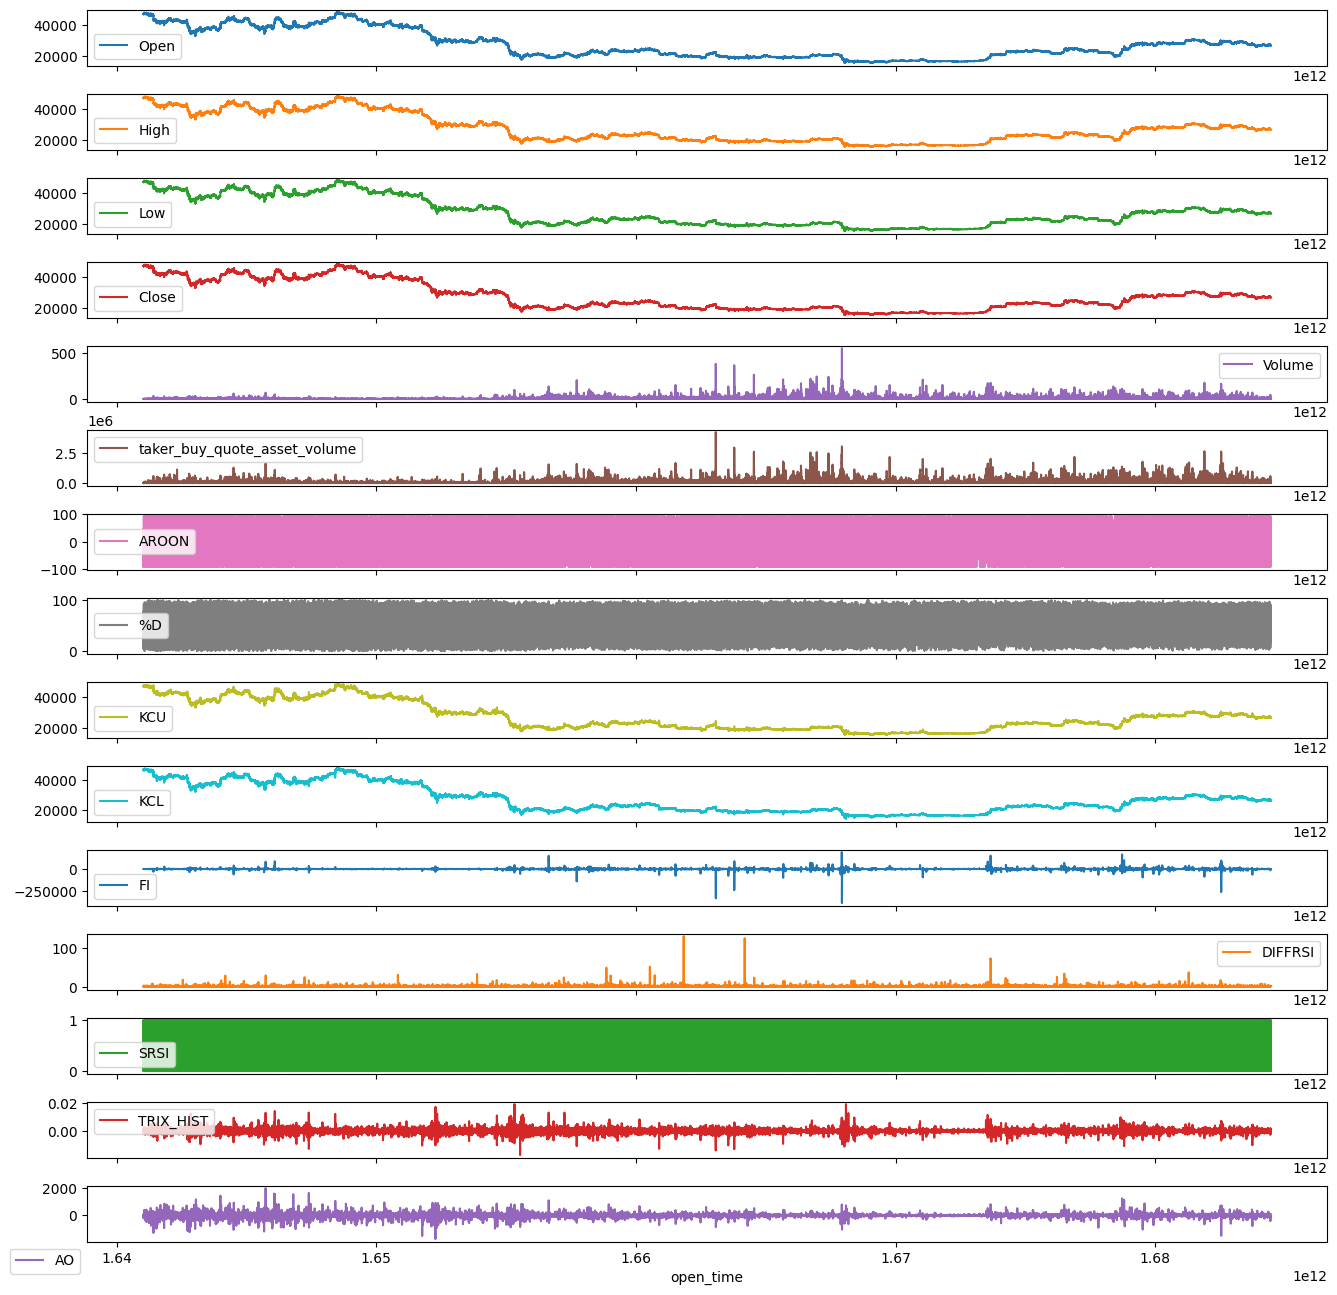

In [8]:
# Visual EDA, show subplots vertically
ax = measurement[measurement.columns].plot(subplots=True, layout=(len(measurement.columns), 1), figsize=(16, 16));
plt.subplots_adjust(hspace=0.5);
plt.legend(loc='upper right', bbox_to_anchor=(0,0), ncol=1);

#### Visualize Cross Correlation Between Observation Features

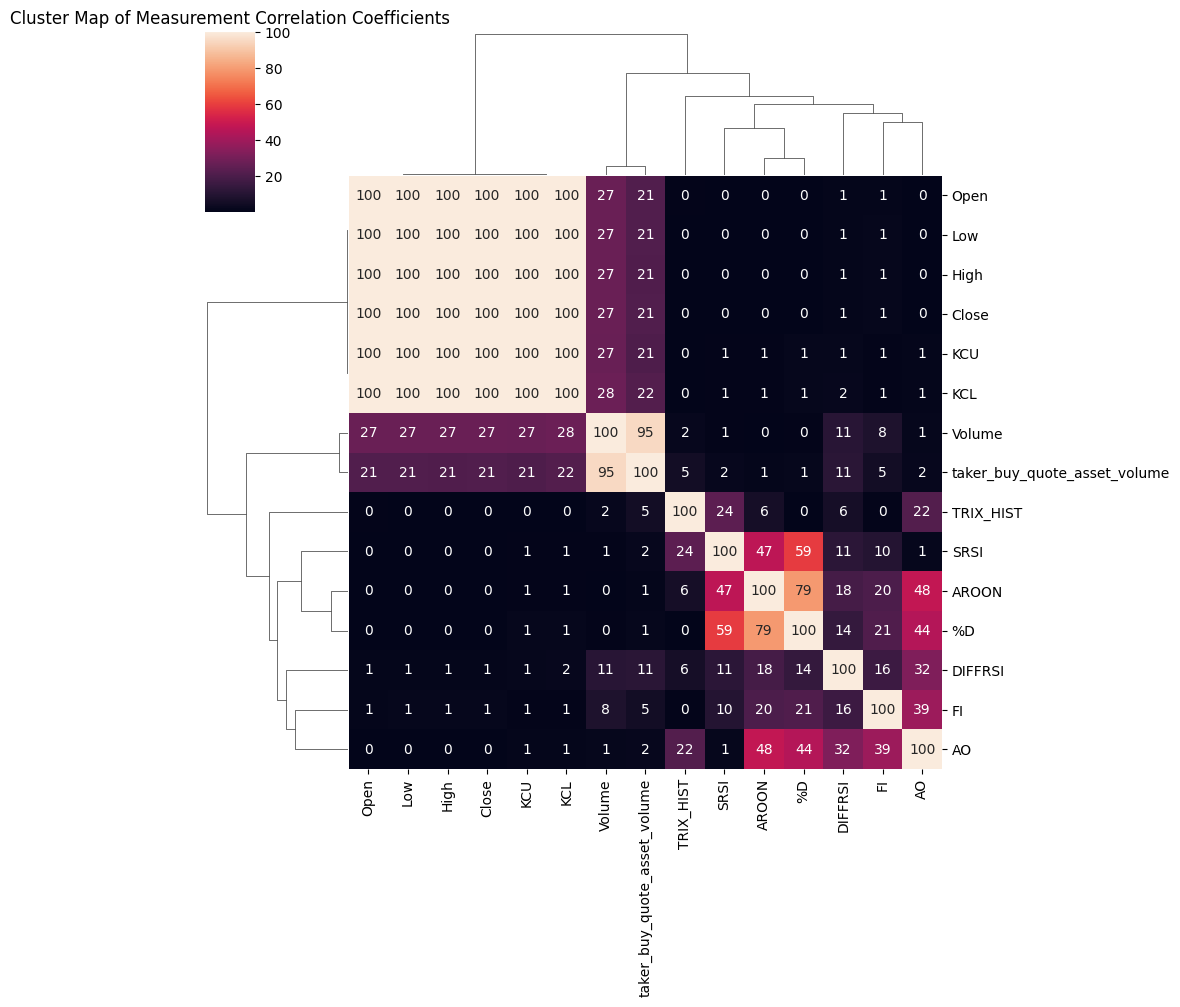

In [9]:
# Plot correlation heatmap and cluster by similar features
ax = sns.clustermap(100*abs(measurement.corr()), annot=True, square=False, fmt='.0f',figsize=(10,10));
plt.title('Cluster Map of Measurement Correlation Coefficients', loc='center');
plt.show();

#### Check for Structure and Correlation in Observation Features

<Axes: xlabel='open_time'>

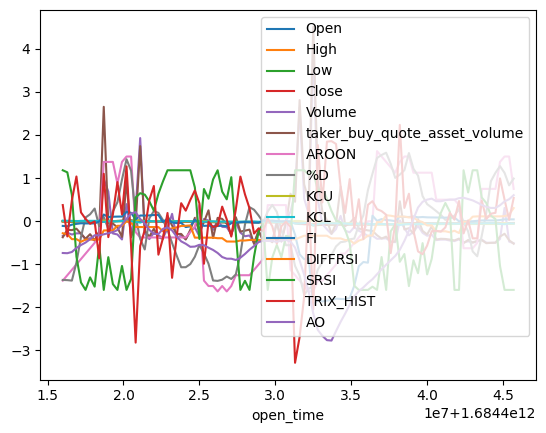

In [10]:
# Plot each of the measurements against each other
((measurement-measurement.mean())/measurement.std())[-100:].plot() 

<Axes: >

KCL                             6.552234
KCU                             6.530166
Low                             6.521070
Open                            6.521067
Close                           6.515210
High                            6.514491
Volume                          3.808451
taker_buy_quote_asset_volume    3.490179
%D                              3.228640
AROON                           3.210508
AO                              2.919065
SRSI                            2.572643
DIFFRSI                         2.269215
FI                              2.246670
TRIX_HIST                       1.657880
dtype: float64

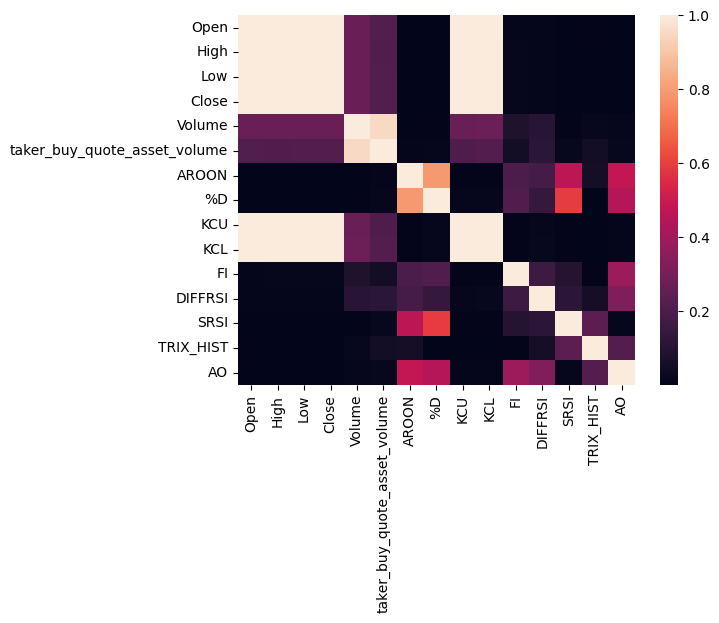

In [11]:
# Take another look at the correlation heatmap
sns.heatmap(abs(measurement.corr())) # Not much cross correlation except for corr(KCU, KCL, open) which is expected
# Heatmap looks good
abs(measurement.corr()).sum().sort_values(ascending=False)

In [12]:
measurement.head()
print('Trade data has ' + str(measurement.shape[0]) + ' observations, '
        + str(measurement.shape[1]) + ' variables.')

,Open,High,Low,Close,Volume,taker_buy_quote_asset_volume,AROON,%D,KCU,KCL,FI,DIFFRSI,SRSI,TRIX_HIST,AO
open_time,,,,,,,,,,,,,,,
1641028200000,47142.39,47142.39,47142.39,47142.39,0.000000,0.000000,-50.0,25.179543,47170.9185,47170.9185,-29.604093,2.268637,0.921130,0.000172,10.694618
1641028500000,47142.39,47142.39,47142.02,47142.02,0.003924,0.000000,-50.0,28.406955,47176.5515,47175.0715,-30.705597,2.268637,0.870136,0.000120,8.697912
1641028800000,47142.02,47142.02,47142.02,47142.02,0.000000,0.000000,-50.0,28.360903,47179.2515,47179.2515,-36.811017,2.268637,0.898510,0.000091,12.269794
1641029100000,47103.27,47124.42,47103.27,47124.42,0.006091,286.978747,-50.0,26.124242,47222.5195,47137.9195,-21.958556,1.749303,1.000000,-0.000079,15.217794
1641029400000,47112.96,47118.73,47112.96,47118.73,0.031840,0.000000,-50.0,23.225421,47190.9215,47167.8415,-24.834712,1.749303,0.948227,-0.000038,13.979676


Trade data has 144634 observations, 15 variables.


#### Create Environment

In [13]:
# Create the CryptoEnvironment instance
window_size = 10
env = CryptoEnvironment(observations=measurement, initial_value = 10000, window_size=window_size, order_fraction=0.66, trade_fee=0)

# Wrap the environment in a vectorized form
env = DummyVecEnv([lambda: env])
%load_ext tensorboard


In [14]:
env.action_space


Discrete(3)

#### Create Agent

In this example we will use the Proximal Policy Optimization which is part of stable-baselines3.

In [16]:
# Create the agent
# model = PPO('MlpPolicy',env,verbose=1,n_steps=64,gamma=0.5,ent_coef=0.5, learning_rate = 0.0001,
#            tensorboard_log="./tensorboard/CUSTOMENV_001")
# model.save("./models/PPO/trading_model_orig.torch")
model = PPO.load('./models/PPO/trading_model_chkpt_orig.torch', env=env) # Load model

#### Train Agent

In [17]:
# Train agent
for i in range(3):
    model.learn(total_timesteps=100,reset_num_timesteps=False)
    # model.save('./models/PPO/' + 'trading_model_chkpt_orig' + '.torch')

Logging to ./tensorboard/CryptoEnvironment\PPO_0
-----------------------------
| time/              |      |
|    fps             | 81   |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1088 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 85            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 1152          |
| train/                  |               |
|    approx_kl            | 0.00014327746 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 0.0623        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.245        |
|    n_updates            | 170           |
|    policy_gradient_loss | -0.00154      |
|    value_loss           | 0.624    

Logging to ./tensorboard/CryptoEnvironment\PPO_0
-----------------------------
| time/              |      |
|    fps             | 70   |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1216 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 71            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 1280          |
| train/                  |               |
|    approx_kl            | 0.00015964359 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -0.159        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.461        |
|    n_updates            | 190           |
|    policy_gradient_loss | -0.00201      |
|    value_loss           | 0.189    

Logging to ./tensorboard/CryptoEnvironment\PPO_0
-----------------------------
| time/              |      |
|    fps             | 67   |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1344 |
-----------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 72             |
|    iterations           | 2              |
|    time_elapsed         | 1              |
|    total_timesteps      | 1408           |
| train/                  |                |
|    approx_kl            | 0.000113093294 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.1           |
|    explained_variance   | -0.0641        |
|    learning_rate        | 0.0001         |
|    loss                 | -0.467         |
|    n_updates            | 210            |
|    policy_gradient_loss | -0.00188       |
|    value_loss      

#### Evaluate Agent

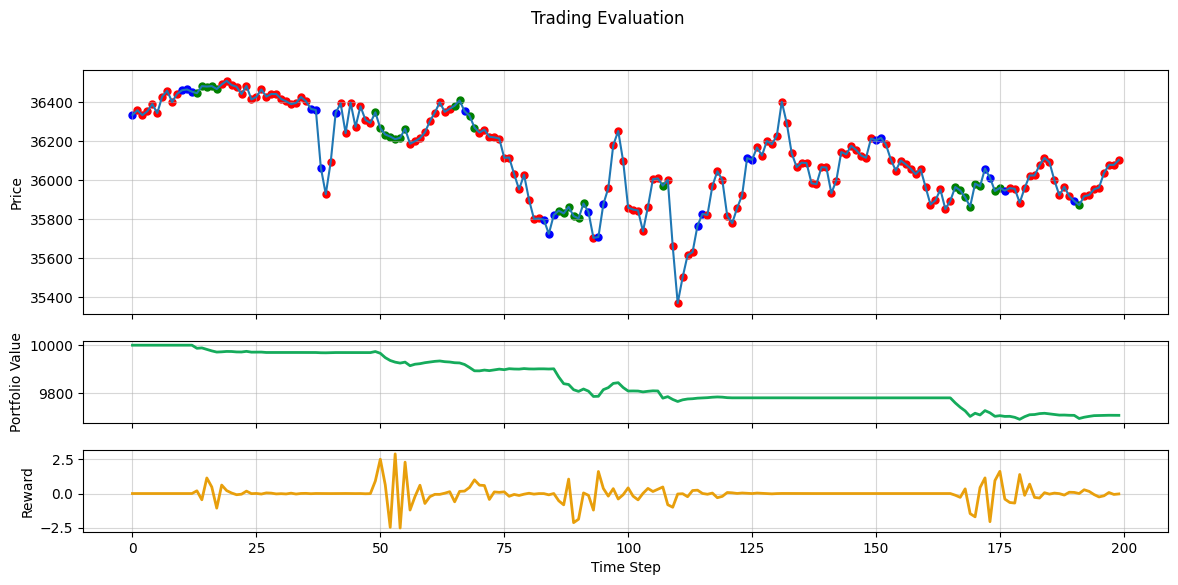

Evaluation Metrics:  
Initial balance:     10000.00
Final value:         9710.57
Profit:              -289.43
Return Rate:         -2.89%
Cumulative reward:   -0.94
Max reward:          2.90
Min reward:          -2.52


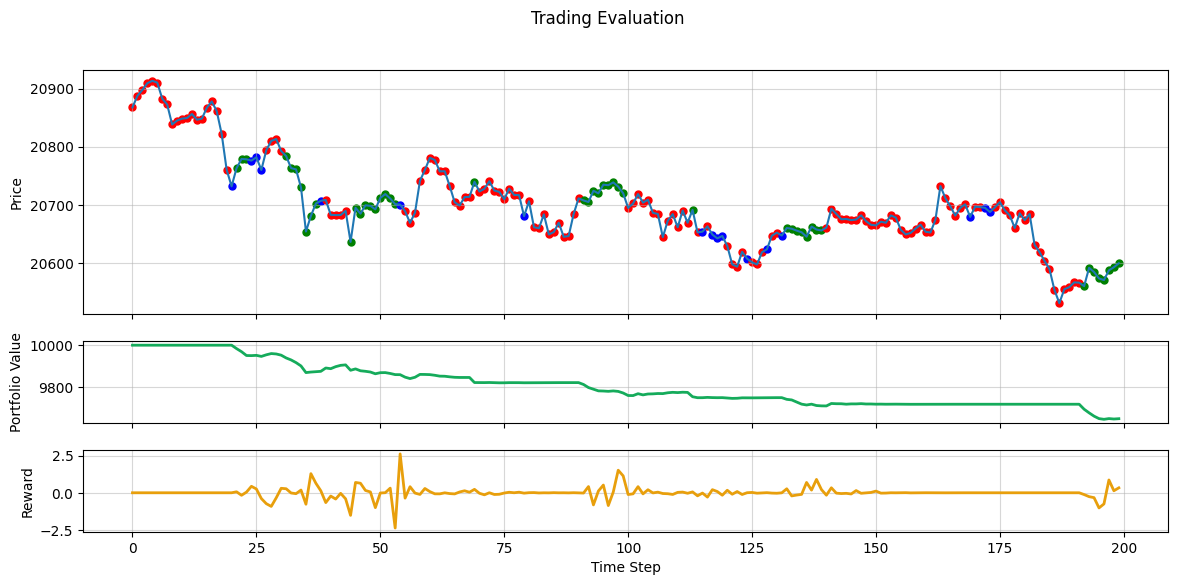

Evaluation Metrics:  
Initial balance:     10000.00
Final value:         9679.51
Profit:              -320.49
Return Rate:         -3.20%
Cumulative reward:   0.82
Max reward:          2.62
Min reward:          -2.38


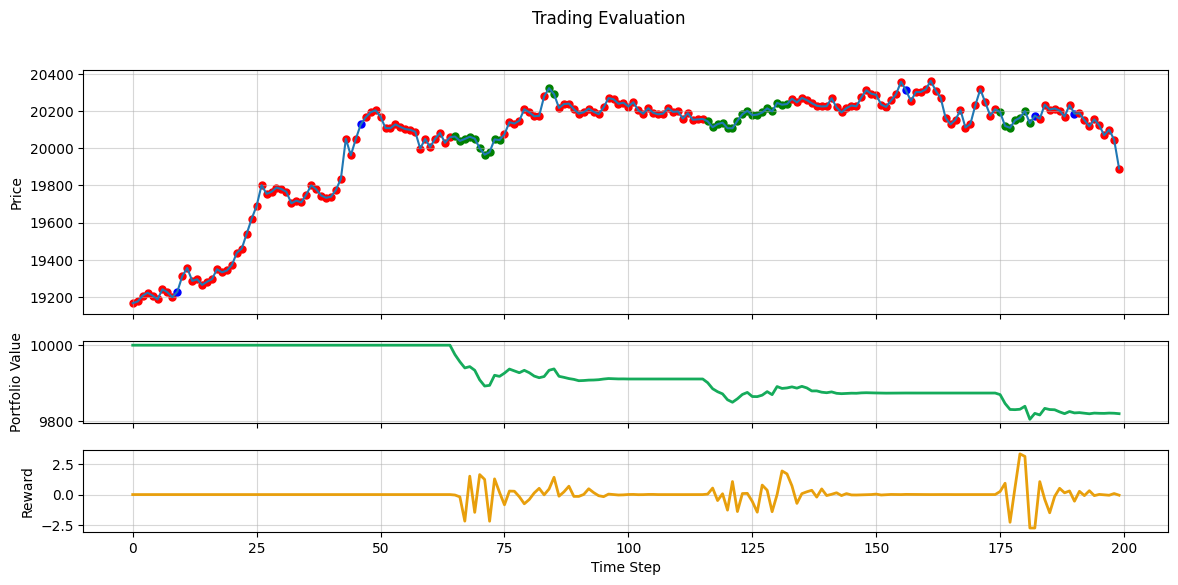

Evaluation Metrics:  
Initial balance:     10000.00
Final value:         9819.73
Profit:              -180.27
Return Rate:         -1.80%
Cumulative reward:   2.80
Max reward:          3.34
Min reward:          -2.74


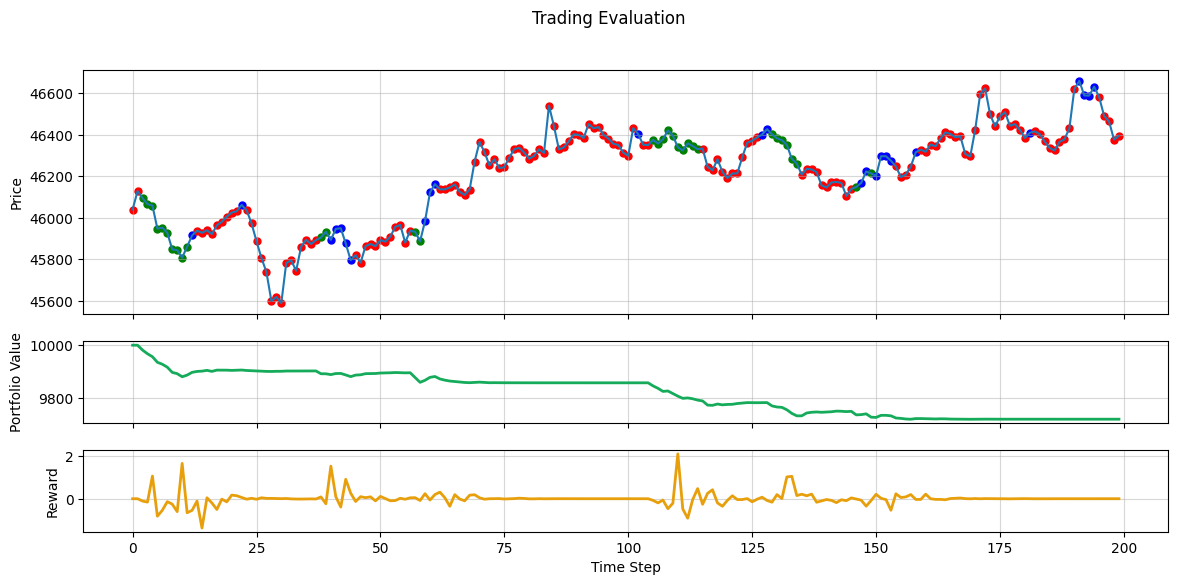

Evaluation Metrics:  
Initial balance:     10000.00
Final value:         9719.41
Profit:              -280.59
Return Rate:         -2.81%
Cumulative reward:   1.78
Max reward:          2.11
Min reward:          -1.38


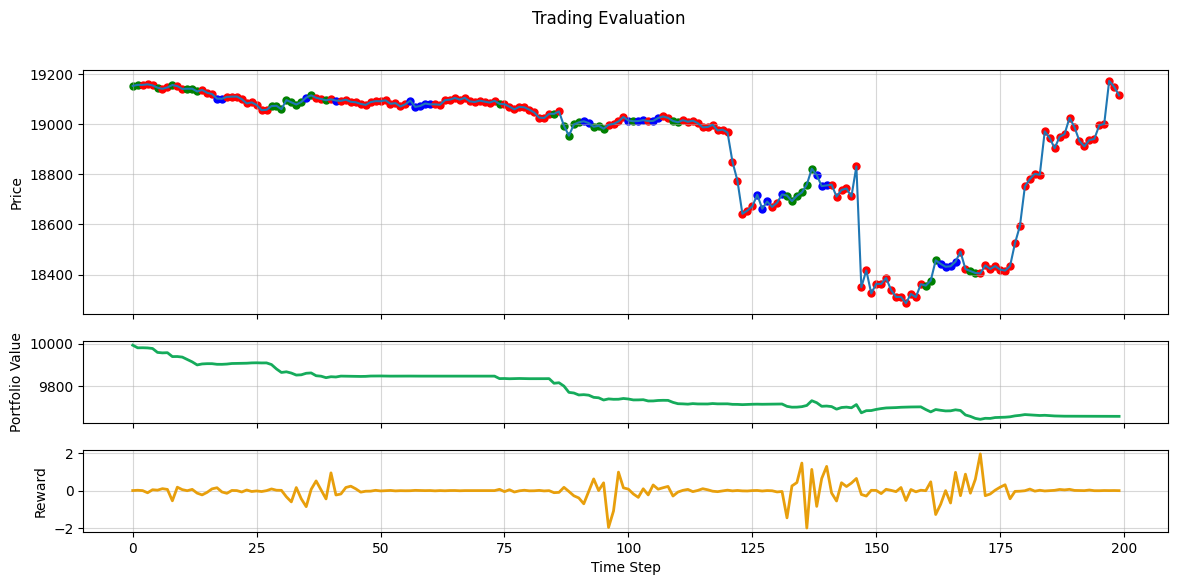

Evaluation Metrics:  
Initial balance:     10000.00
Final value:         9654.81
Profit:              -345.19
Return Rate:         -3.45%
Cumulative reward:   -1.66
Max reward:          1.98
Min reward:          -2.01


In [19]:
# Test the trained agent
# Parameters
for i in range(5):
    initial_value = 10000
    window_size = 10
    frame_length = 50  # Length of the evaluation subset

    # Create the CryptoEnvironment instance
    testenv = CryptoEnvironment(initial_value = 10000, observations = measurement, window_size=window_size, trade_fee=0.00375)

    # Evaluate the model
    testenv.evaluate(frame_length=200, render=True, model=model, marker_size = 25, verbose=1);